In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [19]:
# 1. Data Preparation
data = pd.read_csv('/home/robin/work_root/git/twiced_official/bitcoin-sentiment-index/'
                   'data/02_processed/final_dataset.csv', index_col='Date')
# fill the marketcap with null value
data['MarketCap'] = data['MarketCap'].replace(np.NaN, data['MarketCap'].mean())

# Market Returns - Dependent Variable
y = data['MarketCap'].diff() / data['MarketCap'].shift(1)
y.rename('ret', inplace=True)

# Independent Variables
X = data.iloc[:, 2:]

In [20]:
# 2. Random Forest Regressor
list_lags = []
for i in range(1, 6):
    X_lag = X.shift(i)
    for name in X.columns:
        X_lag.rename(columns={name: f"{name}({-i})"}, inplace=True)
    list_lags.append(X_lag)
    del X_lag

In [21]:
# Features - lagged values of sentiment measures
X_lagged = pd.concat(list_lags, axis=1)
X_lagged.dropna(inplace=True)
y = y.loc[X_lagged.index[0]:]

Try XG BOOST



In [31]:
import xgboost
X_train, X_test, y_train, y_test = train_test_split(X_lagged, y, shuffle=False)
y_test_num = y_test
model = xgboost.XGBRegressor(objective='reg:squarederror',n_estimators=40)
model.fit(X_train,y_train)
y_fitted_xgboost = model.predict(X_test)

# calculate mean sqaured error
error_xgboost = y_fitted_xgboost - y_test
mse_xgboost = sum(error_xgboost*error_xgboost) / len(error_xgboost)
print(mse_xgboost)

xgboost_test_cm = confusion_matrix(y_fitted_xgboost, y_test)
print(xgboost_test_cm)

0.0019206444364543212


ValueError: continuous is not supported

In [5]:
# split train & set data
X_train, X_test, y_train, y_test = train_test_split(X_lagged, y, shuffle=False)
y_test_num = y_test  # for later evaluation of VAR model (calculate MSFE)

RANDOM_STATE = 42
rfr = RandomForestRegressor(n_estimators=500, random_state=RANDOM_STATE,
                            n_jobs=-1, max_features='sqrt')
rfr.fit(X_train, y_train)
y_fitted_rfr = rfr.predict(X_test)

# calculate MSFE of RF Regressor
error_rfr = y_fitted_rfr - y_test
mse_rfr = sum(error_rfr * error_rfr) / len(error_rfr)
print(f'MSFE Random Forest Regressor: {mse_rfr}')

MSFE Random Forest Regressor: 0.001461574690944594


In [6]:
y_test.isnull().sum()


0

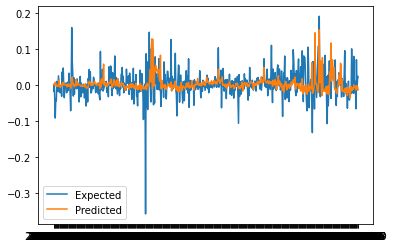

In [7]:
from matplotlib import pyplot as plt
plt.plot(y_test, label='Expected')
plt.plot(y_fitted_rfr, label='Predicted')
plt.legend()
plt.show()

## Trading signal prediction

In [8]:

def sign_ret(num):
    """
    Convert predicted returns into trading signals
    Parameters
    ----------
    num : int
        Any number (in our case predicted returns)
    Returns
    -------
    int
        Trading signals, depends on the signs of predicted returns
        (1 is go long, -1 is go short, 0 is stay still)
    """
    if num > 0:
        return 1
    elif num < 0:
        return -1
    elif num == 0:
        return 0



In [9]:
# Print confusion matrices of train, test data
def evaluate(y_test_fit, y_test_real, y_train_fit=None, y_train_real=None):
    """
    Print confusion matrices and predictive accuracy
    (to evaluate a model's performance).
    Parameters
    ----------
    y_test_fit : Series
        y predicted using test data
    y_test_real : Series
        real y during the test period
    y_train_fit : Series
        y predicted using train data
    y_train_real : Series
        real y during the training period
    Returns
    -------
    NoneType
        None
    """
    test_cm = confusion_matrix(y_test_real, y_test_fit)
    cm_index = ['Negative', 'Zero', 'Positive']
    d_test_cm = pd.DataFrame(test_cm, columns=cm_index, index=cm_index)

    accuracy = ((d_test_cm.iloc[0][0] + d_test_cm.iloc[1][1] +
                 d_test_cm.iloc[2][2]) / d_test_cm.sum().sum())

    print(f'Prediction Accuracy: {round(accuracy * 100, 2)}%.')
    print('--------')
    print('Confusion Matrix (Test Data):')

    print(d_test_cm)
    print('--------')
    if isinstance(y_train_fit, pd.Series):
        train_cm = confusion_matrix(y_train_real, y_train_fit)
        d_train_cm = pd.DataFrame(train_cm, columns=cm_index, index=cm_index)
        print('Confusion Matrix (Train Data):')
        print(d_train_cm)
        print('--------')


In [10]:
y_fitted_rfr = pd.Series(y_fitted_rfr).apply(sign_ret)
y_test = y_test.apply(sign_ret)

y_train_fit_rfr = pd.Series(rfr.predict(X_train)).apply(sign_ret)
y_train = y_train.apply(sign_ret)

print('Random Forest Regressor Performance:')
evaluate(y_fitted_rfr, y_test, y_train_fit_rfr, y_train)

Random Forest Regressor Performance:


ValueError: Shape of passed values is (2, 2), indices imply (3, 3)

In [11]:
y_train[y_train == 1]

Date
2014-12-11    1
2014-12-12    1
2014-12-19    1
2014-12-20    1
2014-12-22    1
             ..
2019-09-04    1
2019-09-08    1
2019-09-12    1
2019-09-13    1
2019-09-20    1
Name: ret, Length: 954, dtype: int64

In [13]:
# checking
test_cm = confusion_matrix(y_fitted_rfr, y_test)

In [14]:
test_cm

array([[154, 106],
       [111, 203]])

Random forest classifier



In [15]:
rfc = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE,
                             n_jobs=-1, max_features='sqrt')

rfc.fit(X_train, y_train)
y_fitted_rfc = pd.Series(rfc.predict(X_test))
#print('Random Forest Classifier Performance:')
#evaluate(y_fitted_rfc, y_test, rfc.predict(X_train), y_train)


In [16]:
test_cm = confusion_matrix(y_fitted_rfc, y_test)


In [17]:
test_cm

array([[167, 147],
       [ 98, 162]])

In [53]:
# # SAVING THE signals into a csv file
# # test signals and its prediction
# actual_test_signals = y_test
# actual_test_signals.rename('actual signals',inplace =True)
# actual_test_signals = pd.DataFrame(actual_test_signals)
# predicted_test_signals = y_fitted_rfr
# predicted_test_signals.rename('predicted signals',inplace =True)
# predicted_test_signals = pd.DataFrame(predicted_test_signals)
# final_test_signals = pd.concat([actual_test_signals,predicted_test_signals.set_index(actual_test_signals.index)],axis=1)
# final_test_signals.head()
# final_test_signals.to_csv('signalPrice.csv')

In [50]:
# get bitcoin price .
bitcoin_price = pd.read_csv("/home/robin/work_root/git/"
                            "twiced_official/bitcoin-sentiment-index/notebooks/data/bitcoin_price.csv",index_col='date')
signal = pd.read_csv('signalPrice.csv',index_col='Date')
#bitcoin_price.head()


In [59]:
signal_price = pd.concat([signal,bitcoin_price],axis=1,join= 'inner')
signal_price.rename_axis('Date')
signal_price.to_csv('test.csv', index_label='Date')

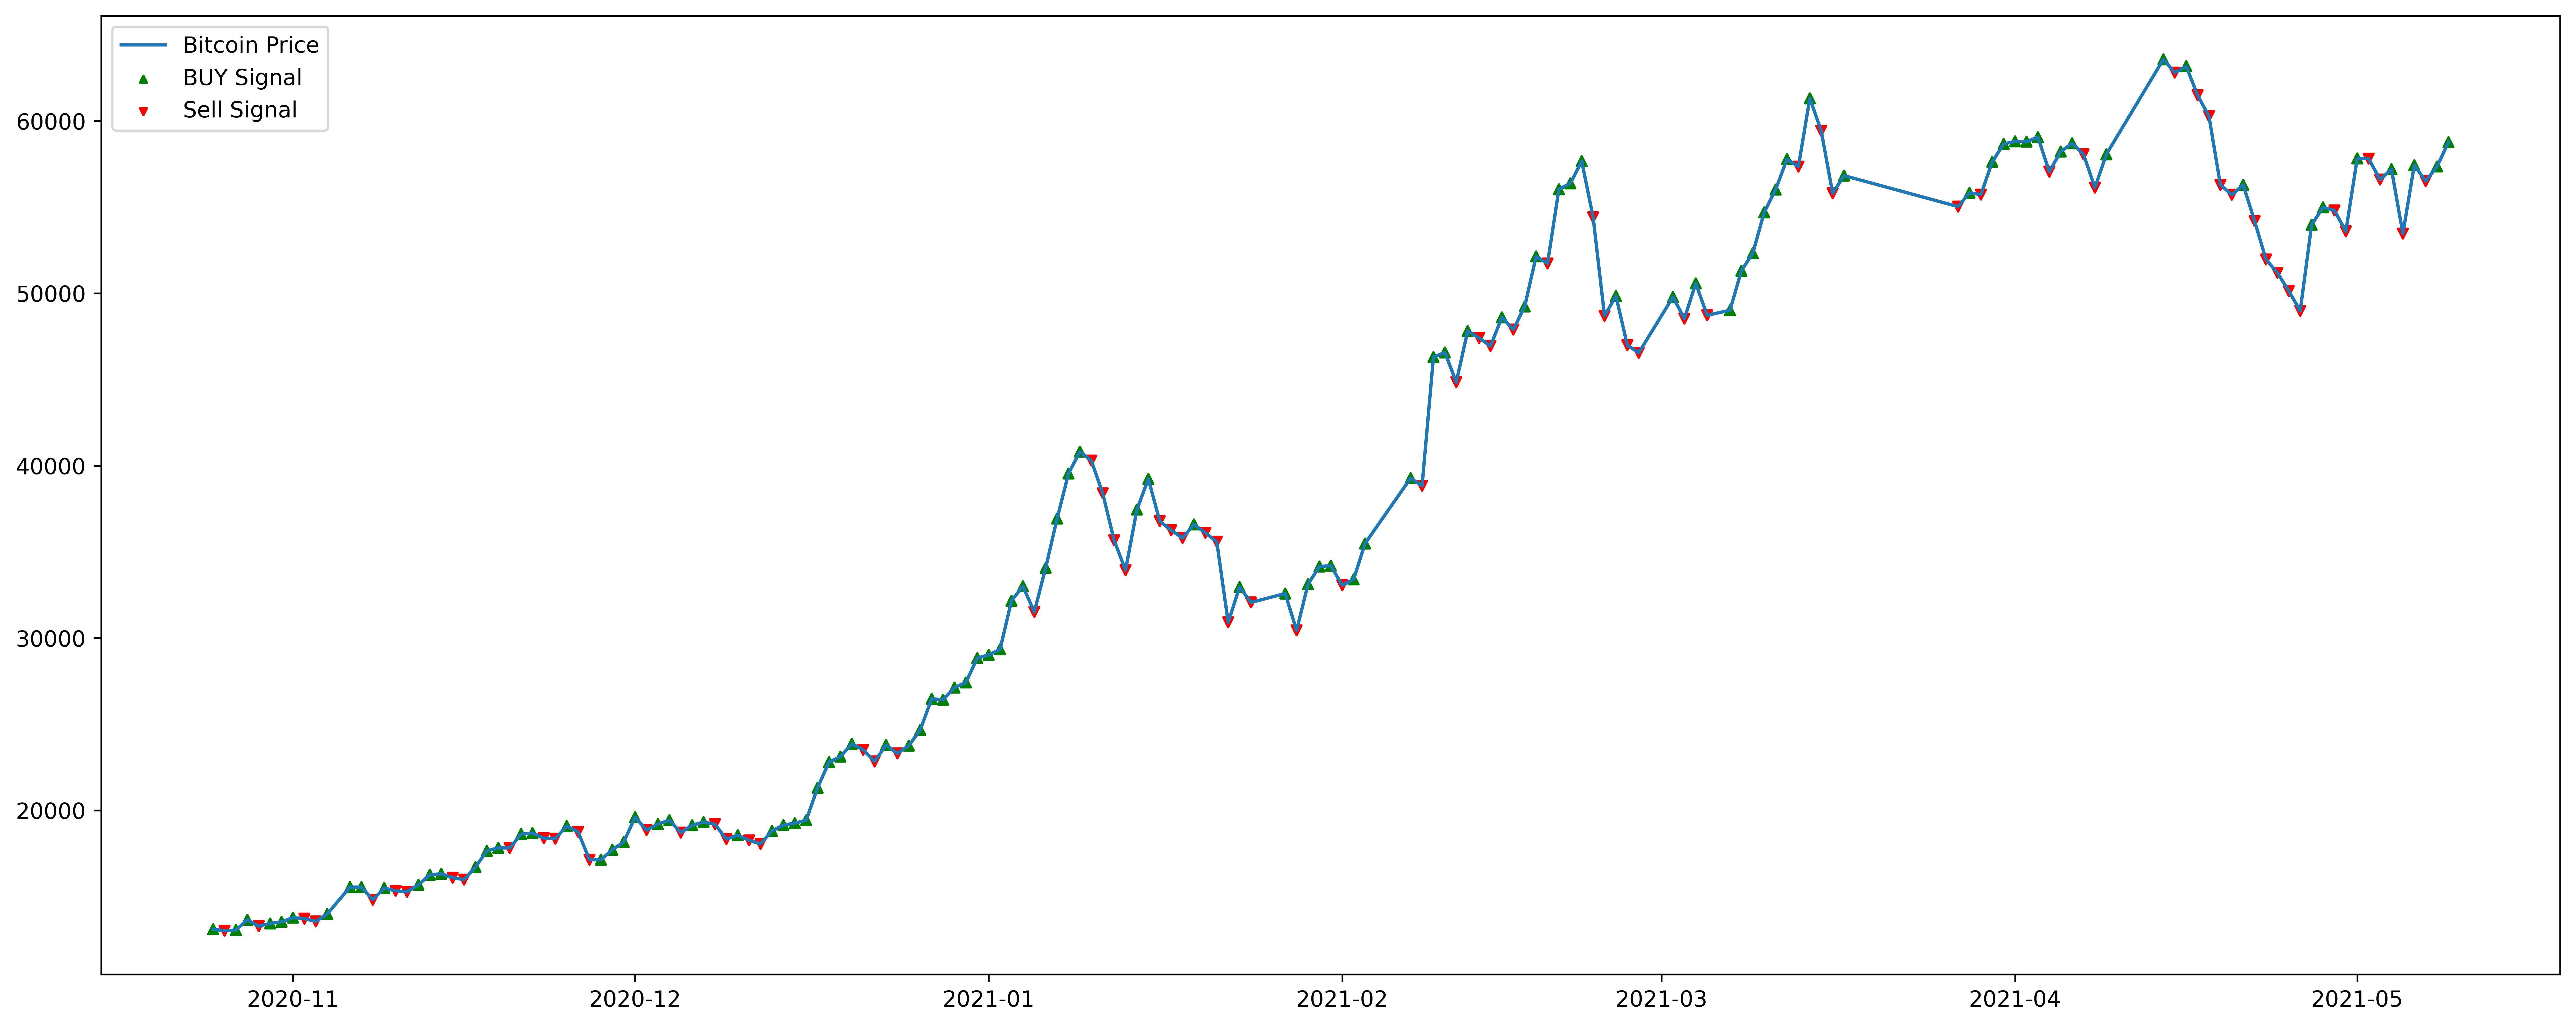

In [89]:
# plotting the bticoin vs trading signals

signal_price = pd.read_csv('test.csv')
signal_price['Date'] = pd.to_datetime(signal_price.Date)
df2 = signal_price.loc[400:]
df2.set_index('Date', inplace=True)
#df2['BitcoinPrice'].plot()

fig = plt.figure(figsize=(20,8), dpi = 600,facecolor='w')

x = df2.index
y = df2['BitcoinPrice']
signal = df2['actual signals']
a = plt.plot(x,y)

b = plt.scatter(x,y, marker='^',
             c='green',s=list(map(lambda a: 20 if a == 1 else 0, signal)))
c = plt.scatter(x,y, marker='v',
            c='red',s=list(map(lambda a: 20 if a == -1 else 0, signal)))


plt.legend([a[0],b,c],['Bitcoin Price','BUY Signal', 'Sell Signal'],
           loc = 'upper left')

plt.savefig('actual_test.png')
plt.show()
